# MLFM for PVLIB 
ver: 221212t18
### Steve Ransome (SRCL) and Juergen Sutterlueti (Gantner Instruments)  
Corrections and additions for comments by : 
Cliff Hansen, Kevin Anderson, Anton Driesse and Mark Campanelli

## Tutorial overview.
see details for each function in mlfm.py

I)   The Loss Factors Model (LFM) 2011 ref [1] quantifies normalised losses  
from module parameters (e.g. pr_dc, i_sc, r_sc, i_mp, v_mp, r_oc and v_oc)  
by analysing module measurements or the shape of the IV curve and comparing  
it with STC reference values from the datasheet.  

II)  The Mechanistic performance model (MPM) 2017 ref [2] has "meaningful,  
independent, robust and normalised" coefficients which fit how the LFM values  
depend on irradiance, module temperature (and windspeed) and time.  

III) This tutorial shows how to take module measured and weather data,  
(either outdoor or IEC 61853-like matrix data), normalise it, generate MLFM  
coefficients, fit them with the MPM then analyse module performance looking for   
loss values, degradation and allowing performance predictions as shown in fig 2.   

Fig 1 illustrates the loss factors model (LFM).  

Depending on the number of measurements available the LFM is defined  
with a suffix number x = 1..12 LFM_n as in ref [4] -  

It uses the shape and values from dc measurements to quantify the values of each  
of the loss factors (coloured arrors on the y=current or x=voltage axes
going from (1) ref\_p\_mp to (6) meas\_p\_mp.  

![mlfm_data/figs/lfm_220914t15.png](mlfm_data/figs/lfm_220914t15.png)  

Fig 1: Loss Factors Model  


![mlfm_data/figs/flow_1024.png](mlfm_data/figs/flow_1024.png)  

Fig 2: MLFM overview flow chart of this tutorial.   

### Explanations of the Loss factors model in fig 1.

1) ref_p_mp = Initial datasheet value at STC.

Multiply by 1/FF to get to (ref_i_sc * ref_v_oc) to start to analyse current and voltage losses  

2->3) Three 'current' losses get from ref_i_sc to norm_i_mp
   - norm_i_sc = measured / expected isc corrected for poa_global (purple)
   - norm_r_sc = loss caused by 'shunt resistance' slope at i_sc (orange)
   - norm_i_ff = loss caused by 'current part' of fill factor (green).  
    
    
4->5) Three 'voltage' losses (plus a temperature coefficient) get from from ref_v_oc to norm_v_mp 
   - norm_temp_corr = optional temp correction subtracted from v_oc (red).    
   - norm_v_oc_t = measured / expected v_oc temp_corrected (brown)   
   - norm_r_oc = loss caused by 'series resistance' slope at v_oc (pink)
   - norm_v_ff = loss caused by 'voltage part' of fill factor (blue)
    
    
6) These losses cause the performance to fall to pr_dc (= meas_p_mp / ref_p_mp)    

pr_dc = 1/ff \*                                    
    (norm_i_sc \* norm_r_sc \* norm_i_ff ) \*             
    (norm_v_ff \* norm_r_oc \* norm_v_oc_t \* norm_temp_corr )   

Note:  
The gamma temperature correction is just subtracted from voc for simplicity.  
In reality there will be temperature dependencies for i_sc and ff but they are smaller.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import mlfm 

from pvlib.mlfm import meas_to_norm, mpm_a_fit, mpm_b_fit, meas_to_stack_lin
from pvlib.mlfm import mpm_a_calc, mpm_b_calc

from pvlib.mlfm import plot_scatter, plot_stack  # , mpm_calc

# FIND AND SHOW INSTALLATION CURRENT WORKING DIRECTORY
import os
root_dir = os.getcwd()

# uncomment to see root dir
# print(root_dir)

# STANDARD DEFINITIONS (also in mlfm.py)
G_STC = 1000.0    # STC irradiance   [W/m^2]
T_STC = 25.0      # STC temperature  [C]        temperature_ref

# https://matplotlib.org/stable/tutorials/introductory/customizing.html
plt.rcParams['figure.figsize'] = [7, 5]  # setup fig size inches       ~[7, 5]
plt.rcParams.update({'font.size': 12})   # setup fontsize              ~12
plt.linewidth = 1.5                      # line width in points        ~1.5
plt.linestyle = '--'                     # solid line                  ~'--'
plt.marker = 's'                         # the default marker square   ~'s'
plt.markersize = 9                       # marker size, in points      ~9
plt.bbox = 1.4                           # offset --> to not overwrite ~1.4


### Get user choices 

In [4]:
# save graphs as png files to the output directory?
save_figs = True

In [5]:
# select which mpm to model : must be 'a original 2017' or 'b advanced 2022'
mpm_sel = 'b'  # 'a' or 'b'

# [A] Select MLFM measurement data file

Three default files are included (\* = version number )  

(0) g78\_T16\_Xall\_F10m\_R900\*.csv  (6 LFM params)  
(1) n05667\_Y13\_R1k6\_fClear\*.csv  (4 LFM params)  
(2) x19074001\_iec61853\*.csv  (4 LFM params)      

(Some variants are added to the IEC 61853 with fewer data points  
or added scatter to test the fit algorithms)

Essential default column names in meas( ) are :-  

meas {  
'date\_time', 'module\_id',  
'poa\_global',  'temp\_module',   
'v\_oc', 'i\_sc', 'i\_mp', 'v\_mp',  
'r\_sc', 'r\_oc',  <-- optional for LFM_6  
'wind\_speed', 'temp\_air', <-- optional  
}


File naming conventions can be used to help identify files, for example  
`x81_T1906_D3_Fh.csv`  

where   
   - x = source e.g. (G)antner, (N)rel, (S)andia, matri(X), ...  
   - 81 = module id/channel number                               
   - T1906 = (T)ime started = yymm(dd)                      
   - D3 = (D)uration in days                             
   - Fh = (F)requency e.g. (h)ours  or (10m)10 minutes      
   - etc.   

In [26]:
# Uncomment just one line to select a file from 
# directory ''\pvlib-python\docs\tutorials\mlfm_data\meas_gtw'

#                                                               PTS   COMMENTS 

# 0) LFM 6 outdoor Gantner Instruments 
# mlfm_meas_file = 'g78_T16_Xall_F10m_R900_041.csv'             # 900   <<< raw data with rsc and roc
# mlfm_meas_file = 'g78_T16_Xall_F10m_R900_041_4param.csv'    # 900   deleted rsc,roc
# mlfm_meas_file = 'g78_T16_Xall_F10m_R1_041.csv'             # 1     test record only

# 1) LFM 4 outdoor NREL 
# mlfm_meas_file = 'n05667_Y13_R1k6_fClear_041.csv'           # 1600  <<< raw data no rsc,roc measured  

# 2) IEC 61853 CFV : either raw data or fewer points and/or added scatter error
# mlfm_meas_file = 'x19074001_iec61853_041.csv'               # 27   <<< raw data no rsc,roc measured  
# mlfm_meas_file = 'x19074001_iec61853_041_6pts.csv'          # 6    raw but fewer points
# mlfm_meas_file = 'x19074001_iec61853_041_rand5pc.csv'       # 27   rand 5% rmse
mlfm_meas_file = 'x19074001_iec61853_041_rand1pc.csv'       # 27   rand 1% rmse
# mlfm_meas_file = 'x19074001_iec61853_041_rand5pc_6pts.csv'  # 6    rand 5% rmse fewer points


# extract module id from filename e.g. 'g78'
mlfm_mod = mlfm_meas_file.split('_')

mlfm_mod_sel = mlfm_mod[0]

### Import measured data (outdoor or matrix)

In [27]:
meas = pd.read_csv(
    # root_dir + '/mlfm_data/meas_gtw/' + mlfm_meas_file,
    os.path.join(root_dir, 'mlfm_data', 'meas_gtw', mlfm_meas_file),
    index_col='date_time'
)

# [B] Read all reference datasheet values at STC

In [28]:
# user must keep updated with their modules from their measurements


ref_file_name  = os.path.join(root_dir, 'mlfm_data', 'ref', 'mlfm_reference_modules.csv')

ref_data = pd.read_csv(
    ref_file_name, index_col='module_id')

### Select module stc data from reference database

In [29]:
try:
    ref_data = ref_data[
        ref_data.index == mlfm_mod_sel]

except IndexError:
    print("You must define module ref data to use this module ...")
    

In [30]:
# Put relevant data into a dict for easy use
# ignore any other columns that may be database specific
# as they aren't needed

ref = dict(
    # module_id=ref_data['module_id'].values[0],
    i_sc=ref_data['i_sc'].values[0],
    i_mp=ref_data['i_mp'].values[0],
    v_mp=ref_data['v_mp'].values[0],
    v_oc=ref_data['v_oc'].values[0],

    alpha_i_sc=ref_data['alpha_i_sc'].values[0],
    beta_v_oc=ref_data['beta_v_oc'].values[0],
    alpha_i_mp=ref_data['alpha_i_mp'].values[0],
    beta_v_mp=ref_data['beta_v_mp'].values[0],
    gamma_pdc=ref_data['gamma_pdc'].values[0],

    p_mp= ref_data['p_mp'].values[0],
    
    
    ff=ref_data['ff'].values[0],
)

# uncomment to show ref data
# ref

### Calculate useful data columns for meas

In [31]:
# calculate p_mp and pr_dc as they might be missing
meas['p_mp'] = meas['i_mp'] * meas['v_mp']

meas['pr_dc'] = (meas['p_mp'] / ref['p_mp']
                 / (meas['poa_global'] / G_STC))

# temperature corrected v_c and pr_dc
meas['v_oc_temp_corr'] = \
    (meas['v_oc'] * (1 - ref['beta_v_oc']*(meas['temp_module'] - T_STC)))

meas['pr_dc_temp_corr'] = \
    (meas['pr_dc'] * (1 - ref['gamma_pdc']*(meas['temp_module'] - T_STC)))

# show some meas data
meas.describe()

,module_id,temp_module,poa_global,i_sc,v_oc,i_mp,v_mp,p_mp,wind_speed,pr_dc,v_oc_temp_corr,pr_dc_temp_corr
count,27.0,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.0,27.000000,27.000000,27.000000
mean,19074001.0,42.222222,581.481481,3.451762,65.341513,3.191874,54.327655,175.784279,0.0,0.923192,67.867073,0.965356
std,0.0,23.588350,358.455058,2.126455,4.838053,1.976012,4.450850,110.950879,0.0,0.077022,2.916070,0.038490
min,19074001.0,15.000000,100.000000,0.586188,54.257739,0.538878,44.791292,24.156797,0.0,0.749502,60.881244,0.859701
25%,19074001.0,25.000000,200.000000,1.216783,61.819074,1.100956,50.166468,61.966794,0.0,0.849704,66.158148,0.951905
50%,19074001.0,50.000000,600.000000,3.577538,65.709173,3.258584,54.298885,178.676199,0.0,0.930519,68.745275,0.976175
75%,19074001.0,62.500000,900.000000,5.325936,69.072708,4.935815,58.162051,270.721147,0.0,0.979747,69.800996,0.992304
max,19074001.0,75.000000,1100.000000,6.616982,72.945871,6.098910,61.126873,357.769360,0.0,1.039431,71.534675,1.023443


### Select LFM_n model by counting variables in the meas data  
usually LFM_4 = matrix (i\_sc, i\_mp, v\_mp, v\_oc)  
and LFM_6 = iv (i\_sc, i\_mp, v\_mp, v\_oc + r\_sc, r\_oc) 

In [32]:
def get_qty_lfm_vars(dmeas):
    """Find the quantity of LFM variables in the measured data.

    (e.g. I_MP+V_MP=2, MATRIX=4, IV_CURVE=6).

    Parameters
    ----------
    dmeas: DataFrame
        Measured weather and module electrical values per time or measurement

    Returns
    -------
    qty_lfm_vars : int
        number of lfm_values present in data usually

        2 = (            i_mp, v_mp            ) from mpp tracker
        4 = (i_sc,       i_mp, v_mp,       v_oc) from matrix
        6 = (i_sc, r_sc, i_mp, v_mp, r_oc, v_oc) from iv curve.

    """
    # find how many lfm variables were measured
    qty_lfm_vars = 0
    for lfm_sel in ('i_sc', 'r_sc', 'i_mp', 'v_mp', 'r_oc', 'v_oc'):
        if lfm_sel in dmeas.columns:
            qty_lfm_vars += 1
            # print(qty_lfm_vars, lfm_sel)

    return qty_lfm_vars

In [33]:
qty_lfm_vars = get_qty_lfm_vars(meas)


# [C]  Normalise LFM values from meas and ref to norm dataframes  



In [34]:
norm = meas_to_norm(meas, ref)

# show some normalised data
norm.head(3)

,poa_global,temp_module,wind_speed,pr_dc,pr_dc_temp_corr,i_sc,i_mp,v_oc,v_oc_temp_corr,v_mp
date_time,,,,,,,,,,
0,100,15,0,0.940226,0.912578,1.020792,0.902408,0.940634,0.917668,0.843822
1,200,15,0,0.962432,0.934130,0.991252,0.934837,0.970955,0.947249,0.831821
2,400,15,0,1.000800,0.971371,1.002495,0.912154,0.988403,0.964271,0.861077


## Make irradiance and temperature bins for pivot tables 

In [35]:
# poa_global bin e.g. 100, 200 .. 1100W/m2
norm['poa_global_bin'] = \
    norm['poa_global'].round(-2)

# temp_module bin e.g. 5, 10 .. 75C
norm['temp_module_bin'] = \
    (5 * round(norm['temp_module'] / 5, 0))

# [D] Perform sanity checks on meas and norm data  

It's easier to sanity check and study normalised data than raw values.  
1) Remove bad, missing, unwanted  or outlier data  
2) User defined limits may depend on data scatter and degradation   
3) Can either select on values e.g. '0.5 <pr_dc < 1.5' or on '>x stdev from mean'  
4) Possible to select on dates if desired.  

In [36]:
# select by irradiance poa_global range e.g. 100-1100 W/m2
norm = norm[(norm['poa_global'] >= 100) &
            (norm['poa_global'] <= 1100)]

# remove specific lfm values outside limits e.g. <0.5 or >1.5
norm = norm[((norm['pr_dc'] > 0.5) &
             (norm['pr_dc'] < 1.5))]

In [37]:
# remove all mlfm values outside x~3 stdevs
if qty_lfm_vars == 6:
    # only needed for outdoor data as indoor ought to be less scattered
    # remove all mlfm data > x stdev usually 3
    stdevs = 3

    for lfm in ('i_sc', 'r_sc', 'i_ff', 'v_ff', 'r_oc', 'v_oc'):
        norm = norm[
            ((norm[lfm] - norm[lfm].mean()) /
                norm[lfm].std()).abs() < stdevs
        ]

## Filter only matching rows from meas and norm data
like an inner join but leave data in separate norm and meas frames

In [38]:
# drop meas rows that aren't in norm
meas_not_in_norm = ~meas.index.isin(norm.index)
meas = meas.drop(meas[meas_not_in_norm].index)

# drop norm rows that aren't in meas
norm_not_in_meas = ~norm.index.isin(meas.index)
norm = norm.drop(norm[norm_not_in_meas].index)

# [E] Plot normalised LFM data vs irradiance  

For outdoor data -  
LFM values norm() should be narrow, smooth lines (around 70-120% on the yaxis).

For matrix data -  
LFM values norm() should be close, almost parallel lines (around 70-120% on the yaxis).

1. Higher values are always better (unlike measured values such as  
    Rseries or Io where lower is better)
1. Accurate measurements and a stable module result in narrowest lines  
1. v_oc and r_sc tend to fall at low light levels ( / left)  
1. r_oc tends to fall at high light levels ( \ right)  
1. i_ff and v_ff are usually fairly flat ( - ) 
1. i_sc may vary the most due to spectral sensitivity, soiling, shading  
    and/or snow (if not properly corrected).    

### Normalised lfm values vs. irradiance.

All traces should be thin, smoot lines usually around 0.9 ± 0.1  
i\_sc may be more scattered if there is uncorrected soiling, spectral and angle of incidence ###

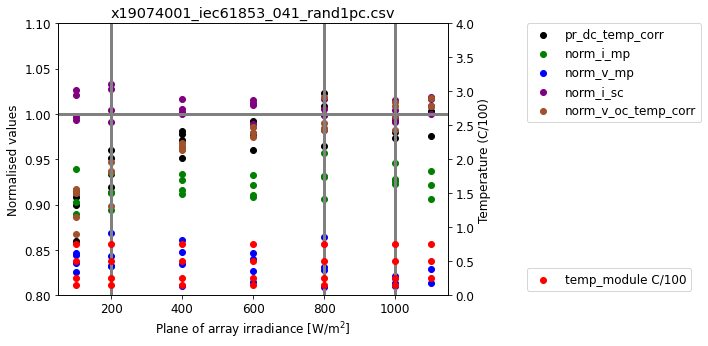

In [39]:
# scatter plot normalised values vs. irradiance
fig_scatter = plot_scatter(
    norm, mlfm_meas_file, qty_lfm_vars, save_figs)


Fig [E] : LFM multiplicative factors (y) vs. poa irradiance (x)


# [F] Convert multiplicative to subtractive losses for a stack plot  

  Multiplicative losses are easier to understand but to represent them on a graph  
it's easier to show them as a stacked plot where the values are 'translated'  
so the sum of the stacked losses is shown to equate to the product of the  
multiplicative losses.

LFM losses can be analysed as either    

- multiplicative  pr_dc = 1/ff * PRODUCT(norm(i_sc),  ...  \* stack(v_oc_t),  stack(temp_corr) ).  

-  subtractive   pr_dc = 1/ff - SUM(stack(i_sc),  ...  stack(v_oc_t),  stack(temp_corr) ).        


In [40]:
# translate multiplicative to stack losses and add to
# dataframe stack add a gap between i and v losses

stack = meas_to_stack_lin(meas, ref, qty_lfm_vars, gap=0.0)  # gap = 0.01


# [G] Plot stack losses vs. measurement  

Fig 3 Shows how to quantify losses by loss parameters stack(i_sc, .. v_oc).  

![stack5D_0_4.png](mlfm_data/figs/mlfm_stack.png)  

Fig 3 Stacked losses by measurement  

- It plots them in a stacked format from the lossless limit 1/ff (top)  
  subtracting each loss value in turn until it reaches pr_dc (bottom).  
  
- This figure shows a typical c-Si module for four clear days for  
  different months July to Oct in AZ.   
  
- In the middle of the days the high irradiance results in the biggest  
  losses being due to r_oc (red, ~rseries, pink) and temp_module  
  (as the module heats to 60C).   
  
- Early mornings/late afternoons there is a slight Isc gain (purple,  
  top, due to spectral mismatch) but an Isc loss mid day due to soiling.  

Stack losses are indicated by their colours  
(from top to bottom for lfm_4=matrix and lfm_6=ivcurve)   

![mlfm_data/figs/losses.png](mlfm_data/figs/losses.png)   

Graph options :  

is_i_sc_self_ref : boolean   
    = self corrects i_sc to remove angle of incidence, spectrum, 
    snow or soiling.  
    
is_v_oc_temp_module_corr : boolean  
    = calc temperature loss due to gamma, subtract from voc loss   

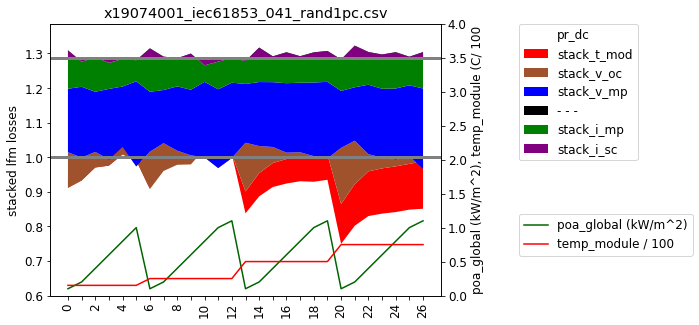

In [41]:
# plot stack loss vs. time (or measurement) chart
fig_stack = plot_stack(
    dstack=stack,                     # dataframe measurements
    fill_factor=ref['ff'],            # dataframe reference STC
    title=mlfm_meas_file,             #
    xaxis_labels=12,                  # show num x_labels or 0 to show all
    is_i_sc_self_ref=False,           # is isc self referenced?
    save_figs=save_figs               # save the figure?
)


Fig [G] Stacked loss values (y) s. date and time (outdoor) or matrix measurement (x)

# [H] Fit mpm to measured weather and normalised losses  

Perform a Mechanistic Performance Model (MPM) fit to the lfm parameters  
poa_global (W/m$^2$), temp_module (C), wind_speed (ms$^-$$^1$).  


mpm_a = c_1 +c_2\*(t_mod-25) +c_3\*log10(g) +c_4\*g +c_5\*ws +c_6\/g  (deprecated)  

mpm_b = c_1 +c_2\*(t_mod–25) +c_3\*log10(g)\*(t_k\/t_stc_k) +c_4\*g +c_5\*ws


Report the fit (coeffs) and error (errs) coefficients.   

### Choose which normalised lfm parameter to model e.g. pr_dc or i_sc..v_oc  

In [42]:
lfm_sel = 'pr_dc'

In [43]:
# add selected variable to measured data frame to ensure data indexes match.
meas_temp = meas.copy()
meas_temp[lfm_sel] = norm[lfm_sel]

# try to fit measurement data and print outputs 

"""
# full_outputboolean, optional
If True, this function returns additioal information: 
    infodict, mesg, and ier.
    
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

mesgstr (returned only if full_output is True)
A string message giving information about the solution.

ierint (returnned only if full_output is True)
An integer flag. If it is equal to 1, 2, 3 or 4, the solution was found. 
Otherwise, the solution was not found. In either case, 
the optional output variable mesg gives more information.
"""

try:
    
    if mpm_sel == 'a':
        cc, coeffs, ee, errs, infodict, mesg, ier = mpm_a_fit(meas_temp, lfm_sel) 
    
    if mpm_sel == 'b':
        cc, coeffs, ee, errs, infodict, mesg, ier = mpm_b_fit(meas_temp, lfm_sel) 
        
        
    # store calculated value of LFM variable
    norm['calc_' + lfm_sel] = cc

    # store residual difference of LFM variable
    norm['diff_' + lfm_sel] = norm[lfm_sel] - norm['calc_' + lfm_sel]
    
    # show infodict data, uncomment fvec to show per row
    print('nfev =',  infodict['nfev'], '\n \n', 
          # 'fvec =',  infodict['fvec'],'\n \n',
          'mesg = ', mesg, '\n \n',
          'ier = ',  ier, "NOTE : if ier in (1,2,3,4) then fit found")
    
except:
    print("CAN'T FIT DATA")


nfev = 22 
 
 mesg =  `ftol` termination condition is satisfied. 
 
 ier =  2 NOTE : if ier in (1,2,3,4) then fit found


# [I] Plot heatmap of mean residual vs. temp_module and poa_global

Show a heatmap of the average residual (meas - fit) error  
for each irradiance (100W/m^2)  and tmod bin (5C).

In [44]:
def plot_heatmap(dnorm, fit, y_axis, x_axis, z_axis,
                 title, save_figs, clip=0.02,):
    """Plot a heatmap of Z vs. binned X and Y axes.

    Parameters
    ----------
     dnorm : dataframe
        Normalised multiplicative loss values (values approx 1).

    fit : string
        fitted parameter e.g. 'pr_dc'.

    x_axis : string
        binned x axis e.g. 'poa_global_bin'.

    y_axis : string
        binned y axis e.g. 'temp_module_bin'.

    z_axis : string
        value as a colour surface plot e.f. 'diff_pr_dc'.

    clip : value
        clipping of z axis usually 0.02

    title : string
        title for graph e.g. mlfm_meas_file.

    """
    df_piv = pd.pivot_table(
        dnorm,
        index=y_axis,       # e.g. 'temp_module_bin'
        columns=x_axis,     # e.g. 'poa_global_bin'
        values=z_axis,      # value to aggregate
        fill_value=0,       # fill empty cells with this ?
        aggfunc=[np.mean],  # e.g. min, np.sum, len->count
        margins=False,      # grand totals hide
        dropna=True         # hide missing rows or columns
    )

    fig, ax1 = plt.subplots()

    # force z limits to be -2% to +2% if desired
    df_piv = df_piv.clip(lower=-clip, upper=+clip)

    im = ax1.imshow(
        df_piv,
        cmap='RdYlBu',
        origin='lower'
    )

    cbar = ax1.figure.colorbar(im, ax=ax1, shrink=0.75, label=z_axis)

    # Y AXIS : show only 1 of each y_skip labels
    y_ticks = df_piv.shape[0]
    plt.yticks(np.arange(0, y_ticks), rotation=0)
    yax2 = [''] * y_ticks
    y_skip = 2
    y_count = 0
    while y_count < y_ticks:
        if y_count % y_skip == 0:
            yax2[y_count] = df_piv.index[y_count]
        y_count += 1

    ax1.set_yticklabels(yax2)
    ax1.set_ylabel(y_axis)

    # X AXIS : show only 1 of each x_skip labels
    x_ticks = df_piv.shape[1]
    plt.xticks(np.arange(0, x_ticks), rotation=90)

    xax2 = [''] * x_ticks
    x_skip = 2
    x_count = 0
    while x_count < x_ticks:
        if x_count % x_skip == 0:
            xax2[x_count] = df_piv.columns.levels[1][x_count]
        x_count += 1

    ax1.set_title(title)

    ax1.set_xticklabels(xax2)
    ax1.set_xlabel(x_axis)

    ax1.grid(color='k', linestyle=':', linewidth=1)

    if save_figs:
        # remove '.csv', high resolution= 300 dots per inch
        plt.savefig(
            os.path.join('mlfm_data', 'output', 'heatmap_' + title[:len(title)-4]),
            dpi=300
        )
                   
    plt.show()


### Residual LFM fit heatmap vs. poa_global and temp_module

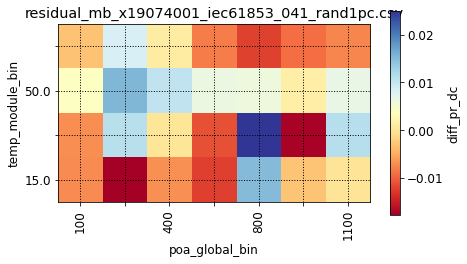

In [45]:
# plot heatmap
heatmap_plot = plot_heatmap(
    dnorm=norm,
    fit=lfm_sel,
    y_axis='temp_module_bin',
    x_axis='poa_global_bin',
    z_axis='diff_' + lfm_sel,
    clip=0.025,
    title='residual_m' + mpm_sel + '_' + mlfm_meas_file,
    save_figs=save_figs
)

Fig [I] Residual LFM fit heatmap vs. poa_global bin (x) and temp_module bin (y)


In [46]:
def plot_fit(dmeas, dnorm, fit, title, save_figs, coeffs):
    """Scatter plot fit to normalised measured.
    
    Parameters
    ----------
    dmeas : dataframe
        measurements, must include 'poa_global_kwm2'

    dnorm : dataframe
        normalised multiplicative lfm loss values 'i_sc' .. 'v_oc'
        where pr_dc = 1/ff * product('i_sc', ... 'v_oc').

    fit : string
        name of fitted variable e.g. 'pr_dc'.

    title : string
        title for graph e.g. mlfm_meas_file.
        
    """
    fig, ax1 = plt.subplots()

    plt.title(title)

    plt.ylabel('fit ' + fit + ' * poa_global kW/m^2')
    ax1.set_ylim(0, 1.2)

    plt.xlabel('meas ' + fit + '* poa_global_kW/m^2')
    ax1.set_xlim(0, 1.2)

    plt.plot(
        dnorm[fit] * dmeas['poa_global'] / G_STC,
        dnorm['calc_' + fit] * dmeas['poa_global'] / G_STC,
        'c^',
        label=fit
    )

    # plot 1:1 line to show optimum fit
    plt.plot((0, 1.2), (0, 1.2), 'yo-')
    
    # plot LIC, NOCT and STC irradiances
    for x in (0.2, 0.8,1): 
        plt.plot((0, x), (x, x), 'k--')
        plt.plot((x, x), (x, 0), 'k--')

    plt.legend(loc='upper left')

    if save_figs:
        # remove '.csv', high resolution= 300 dots per inch
        plt.savefig(
            os.path.join('mlfm_data', 'output', 'fit_meas_' + title[:len(title)-4]),
            dpi=300
        )
                   


    plt.show()


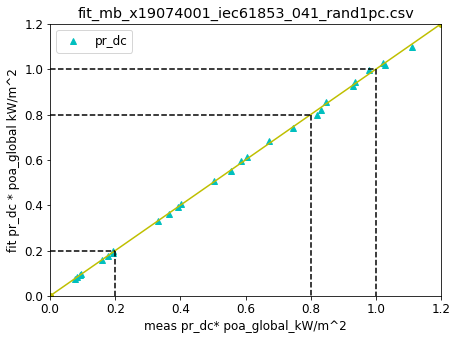

In [47]:
# plot fit vs. measured, include a 1:1 line for comparison
fit_plot = plot_fit(dmeas=meas,
                    dnorm=norm,
                    fit=lfm_sel,
                    title='fit_m' + mpm_sel + '_' + mlfm_meas_file,
                    save_figs=save_figs,
                    coeffs=coeffs
                    )


Fig [J] scatter plot of 'fit_lfm_sel * poa_global# (y) vs. 'measured_lfm_sel * poa_global' (x)

# [K] Read in complete (G,T) Matrix to fill with MLFM predicted values  

Read in a matrix with complete values of   
Irradiance (G=100,200 .. 1100,1200) and module temperature (T=0,5 .. 65,70)  
to predict all MPM values 

In [48]:
# read in the complete matrix data
matr = pd.read_csv(os.path.join(root_dir, 'mlfm_data', 'ref', 'mlfm_matrix.csv'),
                   index_col='id')


## Predict performance from MPM fit coefficients   

1. generate predicted mpm data  
2. create a pivot table mpm(g,t)  
3. show as a heat map

In [49]:
# show model coefficients
mpm_sel, coeffs

('b', array([ 1.05189853, -0.00280426,  0.13154376, -0.05404106,  0.01      ]))

In [50]:
# populate pivot table from predicted mpm data
if mpm_sel == 'a':
    matr[lfm_sel] = mpm_a_calc(matr, *coeffs) # not mpm_sel
    
if mpm_sel == 'b':
    matr[lfm_sel] = mpm_b_calc(matr, *coeffs) # not mpm_sel


matr.head(10)


,mid,poa_global,temp_module,wind_speed,pr_dc
id,,,,,
1,matrix,100,0,0,0.996087
2,matrix,100,5,0,0.979860
3,matrix,100,10,0,0.963633
4,matrix,100,15,0,0.947405
5,matrix,100,20,0,0.931178
6,matrix,100,25,0,0.914951
7,matrix,100,30,0,0.898723
8,matrix,100,35,0,0.882496
9,matrix,100,40,0,0.866269


# [L] Plot heatmap of predicted LFM values vs. temp_mod, poa_global bins

In [51]:
def plot_contourf(df, x_axis, y_axis, z_axis, title,
                  vmin=0, vmax=1.2, levels=5,
                  save_figs=False):
    """Plot filled contour plot Z vs. X and Y bins.

    Parameters
    ----------
    df : dataframe
        measured or normalised data containing weather columns
        (poa_global, temp_module and wind_speed).

    x_axis : string
        binned x axis e.g. 'poa_global'.

    y_axis : string
        binned y axis e.g. 'temp_module'.

    z_axis : string
        measured value as a colour surface plot.

    title : string
        title for graph e.g. mlfm_meas_file.

    vmin, vmax : float
        minimum and maximum values for contour chart ###
        
    """
    piv = pd.pivot_table(
        df,
        index=y_axis,
        columns=x_axis,
        values=z_axis,
        fill_value=0,       # fill empty cells?
        aggfunc=[np.mean],  # min, np.sum, len->count
        margins=False,      # grand totals
        dropna=True         # hide missing rows or columns
    )

    piv = piv.clip(vmin, vmax)

    fig, ax1 = plt.subplots()

    cs = plt.contourf(
        piv,
        cmap='RdYlBu',  # or 'nipy_spectral',
        # origin='lower'
        # nchunkint=1,
        levels=levels,
        vmin=vmin,
        vmax=vmax
    )

    cbar = fig.colorbar(cs, ax=ax1)
    cbar.ax.set_ylabel(z_axis,
                       rotation=90,
                       va='bottom',
                       labelpad=+30)

    plt.title(title)
    # # get_yaxis().set_major_formatter(FormatStrFormatter('%.2f'))

    y_ticks = piv.shape[0]

    plt.yticks(np.arange(0, y_ticks), rotation=0)

    # show only 1 of each y_skip labels
    yax2 = [''] * y_ticks
    y_skip = 2
    y_count = 0
    while y_count < y_ticks:
        if y_count % y_skip == 0:
            yax2[y_count] = piv.index[y_count]
        y_count += 1

    ax1.set_yticklabels(yax2)
    ax1.set_ylabel(y_axis)

    x_ticks = piv.shape[1]
    plt.xticks(np.arange(0, x_ticks), rotation=90)

    # show only 1 of each x_skip labels
    xax2 = [''] * x_ticks
    x_skip = 2
    x_count = 0
    while x_count < x_ticks:
        if x_count % x_skip == 0:
            xax2[x_count] = piv.columns.levels[1][x_count]
        x_count += 1

    ax1.set_xticklabels(xax2)
    ax1.set_xlabel(x_axis)

    ax1.grid(color='k', linestyle=':', linewidth=1)

    if save_figs:
        # remove '.csv', high resolution= 300 dots per inch
        plt.savefig(os.path.join('mlfm_data', 'output', 'contourf_'+ title[:len(title)-4])
                    , dpi=300
                   )      


In [52]:
# REMOVE LOW TEMPERATURE DATA WHICH MAY CONTAIN SNOW

matr2 = matr[matr['temp_module'] >= 10]

### Contour plot of predicted lfm_sel + vs. poa_global and temp_mod. 

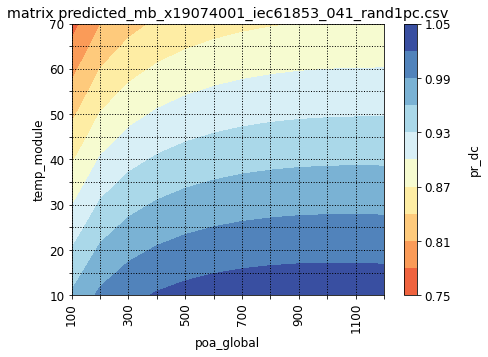

In [53]:
contour_plot = plot_contourf(
    df=matr2,
    y_axis='temp_module',
    x_axis='poa_global',
    z_axis=lfm_sel,
    title='matrix predicted_m' + mpm_sel + '_' + mlfm_meas_file,
    vmin=0.7,
    vmax=1.05,
    levels=9,
    save_figs=save_figs
)

Fig [L1] Contour plot (colours) of predicted lfm_sel  vs. poa_global (x) and temp_mod (y)

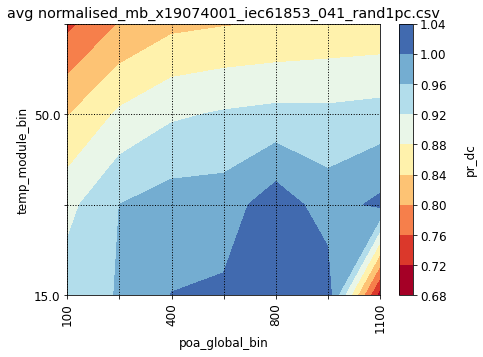

In [54]:
contour_plot = plot_contourf(
    df=norm,
    y_axis='temp_module_bin',
    x_axis='poa_global_bin',
    z_axis=lfm_sel,
    title='avg normalised_m' + mpm_sel + '_' + mlfm_meas_file,
    vmin=0.7,
    vmax=1.05,
    levels=9,
    save_figs=save_figs
)

Fig [L2] Contour plot (colours) of measured lfm_sel  vs. poa_global (x) and temp_mod (y)

## References  
     
The Loss Factors Model (LFM) and Mechanistic Performance Model (MPM)  
together known as "MLFM" have been developed by SRCL and Gantner Instruments  
(previously Oerlikon Solar and Tel Solar) since 2011 MLFM and 2017 MPM  
  
.. [1] J. Sutterlueti(now Gantner Instruments) and  S. Ransome  
 '4AV.2.41 Characterising PV Modules under Outdoor Conditions:  
What's Most Important for Energy Yield'  
26th EU PVSEC 8 September 2011; Hamburg, Germany  
http://www.steveransome.com/pubs/2011Hamburg_4AV2_41.pdf  

.. [2] Steve Ransome and Juergen Sutterlueti(Gantner Instruments)  
  'Choosing the best Empirical Model for predicting energy yield'   
  7th PV Energy Rating and Module Performance Modeling Workshop,  
  Canobbio, Switzerland 30-31 March, 2017  

.. [3] S. Ransome and J. Sutterlueti (Gantner Instruments)  
'Checking the new IEC 61853.1-4 with high quality 3rd party data to  
benchmark its practical relevance in energy yield prediction'  
PVSC June 2019 Chicago, USA  
http://www.steveransome.com/PUBS/1906_PVSC46_Chicago_Ransome.pdf

.. [4] Steve Ransome (SRCL) and Juergen Sutterlueti (Gantner Instruments)  
'5CV.4.35 Quantifying Long Term PV Performance and Degradation  
under Real Outdoor and IEC 61853 Test Conditions  
Using High Quality Module IV Measurements'   
36th EU PVSEC Sep 2019  
http://www.steveransome.com/PUBS/1909_5CV4_35_PVSEC36_Marseille_Ransome_PPT.pdf

.. [5] Steve Ransome (SRCL)  
'How to use the Loss Factors and Mechanistic Performance Models  
effectively with PVPMC/PVLIB'   
PVPMC Webinar on PV Performance Modeling Methods, Aug 2020  
https://pvpmc.sandia.gov/download/7879/  

.. [6] W.Marion et al (NREL)  
'New Data Set for Validating PV Module Performance Models'  
https://www.researchgate.net/publication/286746041_New_data_set_for_validating_PV_module_performance_models  
https://www.nrel.gov/docs/fy14osti/61610.pdf

.. [7] Steve Ransome (SRCL)
'Benchmarking PV performance models with high quality IEC 61853 Matrix
measurements (Bilinear interpolation, SAPM, PVGIS, MLFM and 1-diode)'
http://www.steveransome.com/pubs/2206_PVSC49_philadelphia_4_presented.pdf

.. [8] Juergen Sutterlueti (Gantner Instruments)
'Advanced system monitoring and artificial intelligent data-driven analytics 
to serve GW-scale photovoltaic power plant and energy storage requirements'
https://pvpmc.sandia.gov/download/8574/

Many more papers are available at www.steveransome.com  


In [33]:
# =============================================================================================

In [34]:
## TEST CODE CAN DELETE AFTER HERE IF NOT NEEDED 

test = False

if test: 
    # save meas data to csv
    meas.to_csv(
        os.path.join('mlfm_data', 'output', 'meas.csv'),
        sep=';',
        quotechar='"',
        encoding='utf-8',
        decimal='.'
    )

    # save norm data to csv
    norm.to_csv(
        os.path.join('mlfm_data', 'output', 'norm.csv'),
        sep=';',
        quotechar='"',
        encoding='utf-8',
        decimal='.'
    )

    # save matr data to csv
    matr.to_csv(
        os.path.join('mlfm_data', 'output', 'matr.csv'),
        sep=';',
        quotechar='"',
        encoding='utf-8',
        decimal='.'
    )

    # save ref data to csv
    ref_data.to_csv(
        os.path.join('mlfm_data', 'output', 'ref_data.csv'),
        sep=';',
        quotechar='"',
        encoding='utf-8',
        decimal='.'
    )

    
if test:
    # print mlfm fit coeffs
    print(coeffs[0],coeffs[1],coeffs[2],coeffs[3],coeffs[4],) # coeffs[5], )#coeffs[6],)
    

if test:
    # only works with mlfm_meas_file = 'g78_T16_Xall_F10m_R900_041.
    #
    # check data for test 
    
    n= norm.loc['2016-03-23 09:00:00-07:00']

    print('\n n= \n', n)

    
    n= norm.loc['2016-03-23 09:00:00-07:00']

    print('\n n= \n', n)

    s = stack.loc['2016-03-23 09:00:00-07:00']

    print('\n s= \n', s)


if test:
    # show all versions
    import sys 
    
    for name, module in sorted(sys.modules.items()): 
        if hasattr(module, '__version__'): 
            print (name, module.__version__ )


In [35]:
# whos
